In [18]:
import subprocess
import pydot
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import poisson, norm, chisquare, chi2
import time

import numpy as np
import math

Код для замера времени исполнения генерации

In [29]:
def measure_execution_time(program, num_vertices, density, num_trials):
    total_time = 0
    for _ in range(num_trials):
        start_time = time.time()
        subprocess.run([program, str(num_vertices), str(density)], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        end_time = time.time()
        execution_time = end_time - start_time
        total_time += execution_time
        # print(execution_time)
    average_time = total_time / num_trials
    return average_time

# g++ -std=c++17 -O3 -march=native -I./ -I./randomizer -I./common -I/prufer_graph -I/randomizer -o a main_prufer.cpp
# перед тестированием удалить из программы запись в файл
# subprocess.run(["g++", "-std=c++17", "-O3", "-march=native", "-o", "a", "prufer_prod.cpp"], check=True)
program_name = "a.exe"
num_vertices = 10000
density = 0.1  # плотность 0.1
num_trials = 10
average_execution_time = measure_execution_time(program_name, num_vertices, density, num_trials)
print(f"Average execution time over {num_trials} trials: {average_execution_time:.6f} seconds")

Average execution time over 10 trials: 0.931511 seconds


**Демонстрация генератора**

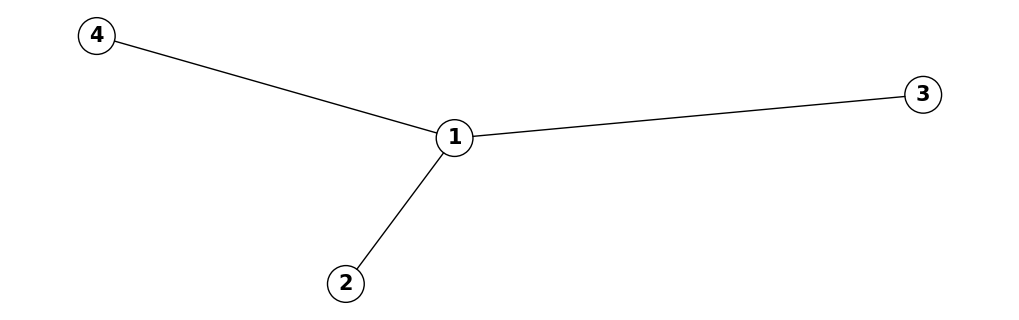

In [56]:
# Компиляция prufer.cpp с помощью g++
#subprocess.run(["g++", "-std=c++17", "-O3", "-march=native", "-o", "a", "prufer.cpp"], check=True)
# Запуск a.exe и ожидание завершения
subprocess.run(["a.exe", "4", "0"], check=True)

# Загружаем граф из файла в формате dot с помощью networkx и pydot
G = nx.nx_pydot.read_dot('graph.dot')

# Рисуем дерево
plt.figure(figsize=(10, 3))
nx.draw(G, 
        with_labels=True, 
        node_size=700,
        node_color="none",
        edgecolors="black",
        font_size=15, 
        font_weight='bold', 
        edge_color='black', 
        font_color='black') 
plt.show()

**Построение гистограммы**

In [3]:
# Функция для чтения рёбер из файла DOT
def read_dot_edges(dot_file):
    edges = []
    with open(dot_file, 'r') as f:
        for line in f:
            if '--' in line:
                parts = line.strip().strip(';').split(' -- ')
                if len(parts) == 2:
                    edges.append(tuple(map(int, parts)))
    return edges

# Функция сбора статистики
def get_sample_4deg(n, trials, density):
    all_degrees = []
    for i in range(trials):
        # Запускаем генерацию графа
        subprocess.run(["a.exe", str(n), str(density)], check=True)
        # Читаем рёбра из файла
        edges = read_dot_edges('graph.dot')
        # Подсчитываем степени вершин
        degree_count = defaultdict(int)  # Сброс перед каждым испытанием
        for u, v in edges:
            degree_count[u] += 1
            degree_count[v] += 1
        # Добавляем степени всех вершин в общий список
        all_degrees.extend(degree_count.values())
    return all_degrees

Использование генератора

In [ ]:
# Количество вершин
n = 100
# Плотность
density = 0.1
# Количество испытаний
trials = 10000
# Список для хранения степеней всех вершин во всех испытаниях
all_degrees = get_sample_4deg(n, trials, density)

# Определяем диапазон значений степеней вершин
min_degree = min(all_degrees)
max_degree = max(all_degrees)

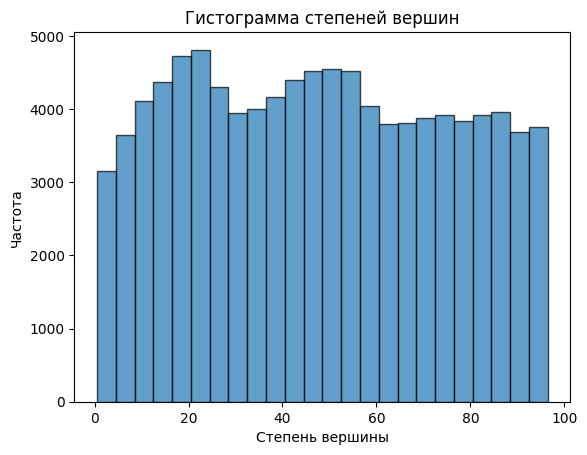

Частоты по бинам: [3158 3643 4108 4376 4723 4812 4303 3942 3995 4162 4394 4524 4544 4519
 4037 3802 3808 3880 3915 3838 3919 3961 3689 3761]
Границы бинов: [ 0.5  4.5  8.5 12.5 16.5 20.5 24.5 28.5 32.5 36.5 40.5 44.5 48.5 52.5
 56.5 60.5 64.5 68.5 72.5 76.5 80.5 84.5 88.5 92.5 96.5]


In [65]:
# Число бинов
num_bins = (n - 1)//4  # Бины от 1 до N-1, то есть, для 4 вершин, бины от 1 до 3
# Определяем границы бинов
bin_edges = np.arange(0.5, n + 0.5, n/(num_bins + 1))

# Строим гистограмму степеней вершин с использованием указанных границ бинов
plt.hist(all_degrees, bins=bin_edges, edgecolor='black', alpha=0.7)
plt.title('Гистограмма степеней вершин')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')

# Показать гистограмму
plt.show()

'''
# Используем логарифмическую оценку для количества бинов
num_bins = n#math.ceil(math.log2(len(all_degrees)) + 1)

# Строим гистограмму степеней вершин
plt.hist(all_degrees, bins=num_bins, edgecolor='black', alpha=0.7)
plt.title('Гистограмма степеней вершин')
plt.xlabel('Степень вершины')
plt.ylabel('Частота')
plt.show()
'''
hist_values, bin_edges = np.histogram(all_degrees, bins=bin_edges)

# Выводим частоты для каждого бина
print("Частоты по бинам:", hist_values)
print("Границы бинов:", bin_edges)

Анализ гистограммы с ипользованием построения в c++

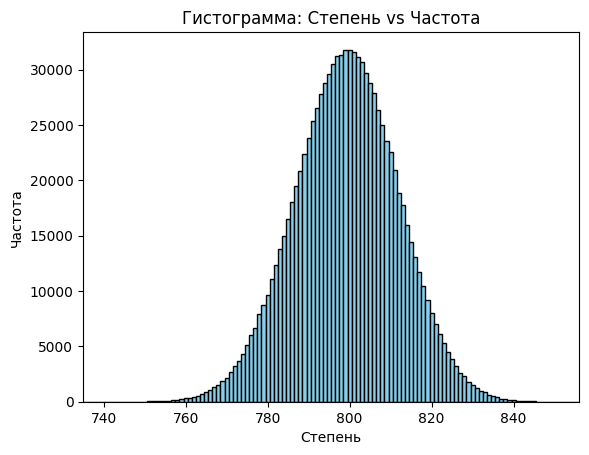

In [106]:
import numpy as np

def read_vector_from_file(filename):
    with open(filename, 'rb') as file:
        # Читаем размер вектора
        size = np.fromfile(file, dtype=np.uint64, count=1)[0]

        # Читаем данные вектора
        vec = np.fromfile(file, dtype=np.int32, count=size)

    return vec

# Чтение вектора из файла
deg = read_vector_from_file('histogram.bin')[1:] # степени 0 быть не может, т.к. граф связен по построению
#deg = deg[60:]
deg = deg[1:-2]
# Выводим содержимое вектора
# print(deg)

degrees = np.arange(len(deg))

# Определяем границы по ненулевым значениям
nonzero_indices = np.nonzero(deg)[0]
xmin, xmax = nonzero_indices[0], nonzero_indices[-1]
# Построение гистограммы
plt.bar(degrees, deg, width=1.0, align='center', color='skyblue', edgecolor='black')
plt.xlim([xmin, xmax])
# Настройка подписей и заголовка
plt.xlabel('Степень')
plt.ylabel('Частота')
plt.title('Гистограмма: Степень vs Частота')

# Отображение графика
plt.show()

**Проверка гипотезы о нормальности**

Среднее: 799.20, СКО: 12.58
Статистика критерия хи-квадрат: 493.19
Критическое значение хи-квадрат при alpha=0.01: 150.88
Гипотеза о нормальности отвергается.


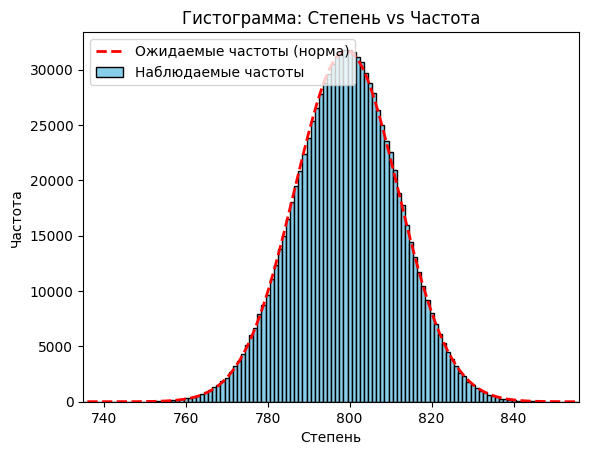

In [107]:
# Индексы степеней (x-координаты)


degrees = np.arange(len(deg))

# Находим среднее и стандартное отклонение по данным (с учетом частот)
mean = np.average(degrees, weights=deg)
std_dev = np.sqrt(np.average((degrees - mean) ** 2, weights=deg))

# Вычисление ожидаемых частот
total_count = np.sum(deg)  # Общее количество данных
expected_freq = total_count * norm.pdf(degrees, mean, std_dev)  # Переводим PDF в частоты

# Коррекция малых значений, чтобы избежать деления на 0
expected_freq[expected_freq < 1e-6] = 1e-6

# Вычисление статистики хи-квадрат
chi_statistic = np.sum((deg - expected_freq) ** 2 / expected_freq)

# Число степеней свободы (уменьшаем, если объединяем редкие классы)
df = len([i for i in deg if i > 0]) - 3 #len(degrees) - 3  # Отнимаем 1 за число параметров (μ, σ) и 1 за нормализацию

# Критическое значение хи-квадрат
alpha = 0.01
chi_critical = chi2.ppf(1 - alpha, df)

# Вывод результатов
print(f"Среднее: {mean:.2f}, СКО: {std_dev:.2f}")
print(f"Статистика критерия хи-квадрат: {chi_statistic:.2f}")
print(f"Критическое значение хи-квадрат при alpha={alpha}: {chi_critical:.2f}")

# Проверка гипотезы
if chi_statistic < chi_critical:
    print("Гипотеза о нормальности НЕ отвергается.")
else:
    print("Гипотеза о нормальности отвергается.")

# Визуализация
plt.bar(degrees, deg, width=1.0, align='center', color='skyblue', edgecolor='black', label="Наблюдаемые частоты")
plt.plot(degrees, expected_freq, color='red', linestyle='dashed', linewidth=2, label="Ожидаемые частоты (норма)")
plt.xlim([xmin, xmax])

plt.xlabel('Степень')
plt.ylabel('Частота')
plt.title('Гистограмма: Степень vs Частота')
plt.legend()
plt.show()

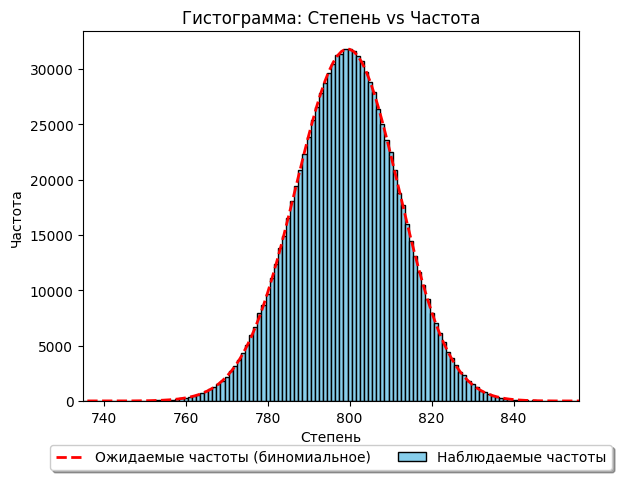

Среднее: 799.20, СКО: 12.54
Статистика критерия хи-квадрат: 178.56
Критическое значение хи-квадрат при на уровне значимости 1 - alpha = 0.99: 152.04
Гипотеза о биномиальном распределении отвергается.


In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, binom


# Индексы степеней (x-координаты)
degrees = np.arange(len(deg))

# Оценка параметров биномиального распределения
n = degrees.max()  # Максимальная степень как число испытаний
p = np.sum(degrees * deg) / (n * np.sum(deg))  # Оценка вероятности успеха

# Вычисление ожидаемых частот по биномиальному распределению
total_count = np.sum(deg)
expected_freq = total_count * binom.pmf(degrees, n, p)

# Коррекция малых значений, чтобы избежать деления на 0
expected_freq[expected_freq < 1e-6] = 1e-6

# Вычисление статистики хи-квадрат
chi_statistic = np.sum((deg - expected_freq) ** 2 / expected_freq)

# Число степеней свободы
df = len([i for i in deg if i > 0]) - 2  # Отнимаем 1 за n и 1 за p

# Критическое значение хи-квадрат при alpha=0.05
alpha = 0.01
chi_critical = chi2.ppf(1 - alpha, df)

# Вывод результатов
mean_binom = n * p
std_dev_binom = np.sqrt(n * p * (1 - p))

# Определяем границы по ненулевым значениям
nonzero_indices = np.nonzero(deg)[0]
xmin, xmax = nonzero_indices[0], nonzero_indices[-1]

# Визуализация результатов биномиального распределения
plt.bar(degrees, deg, width=1.0, align='center', color='skyblue', edgecolor='black', label="Наблюдаемые частоты")
plt.plot(degrees, expected_freq, color='red', linestyle='dashed', linewidth=2, label="Ожидаемые частоты (биномиальное)")

plt.xlabel('Степень')
plt.ylabel('Частота')
plt.title('Гистограмма: Степень vs Частота')
plt.xlim([xmin, xmax])  # Устанавливаем границы оси X

# Вывод легенды под график
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
plt.show()

# Вывод результатов
print(f"Среднее: {mean_binom:.2f}, СКО: {std_dev_binom:.2f}")
print(f"Статистика критерия хи-квадрат: {chi_statistic:.2f}")
print(f"Критическое значение хи-квадрат при на уровне значимости 1 - alpha = {1 - alpha}: {chi_critical:.2f}")

# Проверка гипотезы
if chi_statistic < chi_critical:
    print("Гипотеза о биномиальном распределении НЕ отвергается.")
else:
    print("Гипотеза о биномиальном распределении отвергается.")

In [97]:
p, n

(0.5, 95)